In [1]:
import pickle
import torch
import time
import sys

import numpy as np
import seaborn as sns

from torch import nn
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms

sys.path.append('..')

In [2]:
from torchmetrics.classification import BinaryPrecision
precision = BinaryPrecision()

from torchmetrics.classification import BinaryRecall
recall = BinaryRecall()

from latents_dataset import load as load_latents_dataset

from utils.custom_dataset import CustomDataset

data_path = '/home/robert/data/diploma-thesis/datasets/stylegan3/tpsi_1/latents/sample_z.h5'
targets_path = '/home/robert/data/diploma-thesis/predictions/stylegan3/tpsi_1/resnet34_eyeglasses.pkl'

batch_size = 64

train_loss_per_epoch, train_acc_per_epoch = [], []
valid_loss_per_epoch, valid_acc_per_epoch = [], []

In [3]:
latents, targets = load_latents_dataset(data_path, targets_path)

<AxesSubplot: ylabel='Count'>

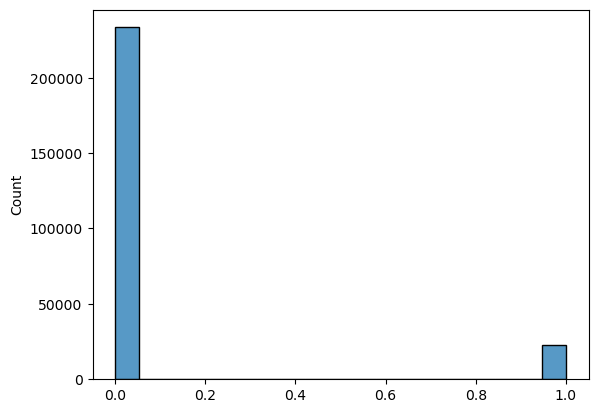

In [4]:
targets = np.round(targets)
sns.histplot(targets)

In [5]:
targets[targets == 1].shape

(22547,)

In [6]:
targets[targets == 0].shape

(233453,)

In [7]:
zero_indices = np.where(targets == 0)[0]
zero_indices = np.random.choice(zero_indices, 22547, replace=False)
zero_indices.shape

(22547,)

In [8]:
one_indices = np.where(targets == 1)[0]
indices = np.concatenate((one_indices, zero_indices))
indices.shape

(45094,)

<AxesSubplot: ylabel='Count'>

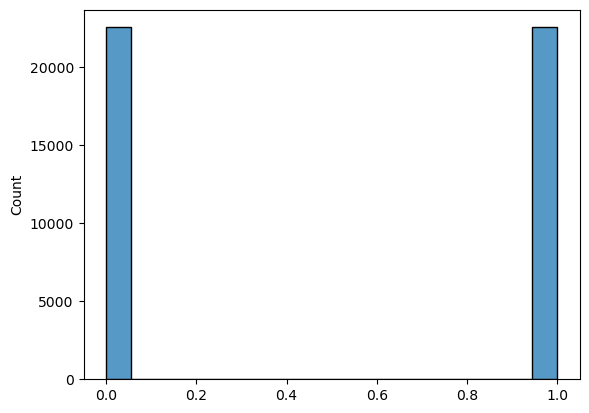

In [9]:
targets = targets[indices]
latents = latents[indices]
sns.histplot(targets)

In [10]:
print(latents.shape, targets.shape)

(45094, 512) (45094,)


In [11]:
transform = transforms.Compose([])
target_transform = transforms.Compose([torch.round])
dataset = CustomDataset(latents, targets, transform=transform, target_transform=target_transform)
train_data, valid_data, test_data = random_split(dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))

In [12]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:
for X, y in test_dataloader:
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of X [N, C, H, W]: torch.Size([64, 512])
Shape of y: torch.Size([64, 1]) torch.float32


In [14]:
device = 'cpu'
if torch.cuda.is_available( ):
    device = 'cuda'

In [3]:
class LatentEncoder(nn.Module):
    def __init__(self, input_shape=(64, 512), num_classes=1):
        super(LatentEncoder, self).__init__()
    
        self.encoder = nn.Sequential(
            nn.Linear(input_shape[1], 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(0.125),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(0.125),
            nn.ReLU(),
            nn.Linear(32, num_classes),
        )

        self.sigmoid = nn.Sigmoid()

        def init_weights(m):
            if type(m) in [nn.Linear, nn.Conv2d]:
                nn.init.kaiming_uniform_(m.weight)

        self.encoder.apply(init_weights)

    def forward(self, x):
        return self.sigmoid(self.encoder(x))

In [37]:
def train(dataloader, model, loss_fn, optimizer):
    train_loss, train_acc = 0, 0
    num_batches = len(dataloader)

    size = len(dataloader.dataset)
    model.train()
    start = time.time()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)

        loss = loss_fn(pred, y.float())
        train_loss += loss.item()

        acc = torch.round(pred).eq(y).sum().cpu().numpy()/len(y[0])/len(y)
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            end = time.time()
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}] time: {end-start} acc: {acc}')
            start = time.time()

    train_loss /= num_batches
    train_acc /= num_batches

    train_loss_per_epoch.append(train_loss)
    train_acc_per_epoch.append(train_acc)

In [38]:
def valid(dataloader, model, loss_fn, save_filename=None):
    num_batches = len(dataloader)
    model.eval()
    valid_loss, valid_acc, valid_precision, valid_recall = 0, 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y.float()).item()
            valid_acc += torch.round(pred).eq(y).sum().cpu().numpy()/len(y[0])/len(y)
            valid_precision += precision(pred.cpu(), y.cpu())
            valid_recall += recall(pred.cpu(), y.cpu())

    valid_loss /= num_batches
    valid_acc /= num_batches
    valid_precision /= num_batches
    valid_recall /= num_batches

    print(f'Valid Error: \n Accuracy: {valid_acc:>8f}, Precision: {valid_precision:>8f}, Recall: {valid_recall:>8f}, Avg loss: {valid_loss:>8f} \n')

    valid_loss_per_epoch.append(valid_loss)
    valid_acc_per_epoch.append(valid_acc)

In [39]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.float()).item()
            test_acc += torch.round(pred).eq(y).sum().cpu().numpy()/len(y[0])/len(y)
    
    test_loss /= num_batches
    test_acc /= num_batches
    print(f'Test Error: \n Accuracy: {test_acc:>0.8f}, Avg loss: {test_loss:>8f} \n')

In [46]:
input_shape = (batch_size, len(dataset[0][0]))
model = LatentEncoder(input_shape=input_shape).to(device)

print(model)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = StepLR = StepLR(optimizer, step_size=1, gamma=0.1)

epochs = 20
for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_dataloader, model, loss_fn, optimizer)
    # scheduler.step()
    valid(valid_dataloader, model, loss_fn)
print('Done!')

test(test_dataloader, model, loss_fn)

LatentEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Dropout(p=0.25, inplace=False)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Dropout(p=0.125, inplace=False)
    (8): Sigmoid()
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)
Epoch 1
-------------------------------
loss: 0.704532  [    0/36076] time: 0.009621381759643555 acc: 0.5
loss: 0.585433  [ 6400/36076] time: 0.2982919216156006 acc: 0.71875
loss: 0.509709  [12800/36076] time: 0.23776721954345703 acc: 0.75
loss: 0.407762  [19200/36076] time: 0.23740649223327637 acc: 0.8125
loss: 0.399051  [25600/36076] time: 0.23833680152893066 acc: 0.796875
loss: 0.542961  [32000/36076] time: 0.23816633224487305 acc: 0.78125
Valid Error: 
 Accuracy: 0.799948, Precision: 0.749916, Recall: 0.

loss: 0.254259  [ 6400/36076] time: 0.2391681671142578 acc: 0.875
loss: 0.358729  [12800/36076] time: 0.23799490928649902 acc: 0.875
loss: 0.214481  [19200/36076] time: 0.2382042407989502 acc: 0.9375
loss: 0.258852  [25600/36076] time: 0.23868346214294434 acc: 0.90625
loss: 0.362393  [32000/36076] time: 0.23851609230041504 acc: 0.828125
Valid Error: 
 Accuracy: 0.783003, Precision: 0.721494, Recall: 0.920959, Avg loss: 0.676721 

Epoch 16
-------------------------------
loss: 0.336394  [    0/36076] time: 0.004118442535400391 acc: 0.90625
loss: 0.208774  [ 6400/36076] time: 0.23841452598571777 acc: 0.921875
loss: 0.196576  [12800/36076] time: 0.2379920482635498 acc: 0.9375
loss: 0.445394  [19200/36076] time: 0.2395477294921875 acc: 0.828125
loss: 0.207681  [25600/36076] time: 0.24022412300109863 acc: 0.90625
loss: 0.287161  [32000/36076] time: 0.23798727989196777 acc: 0.890625
Valid Error: 
 Accuracy: 0.793786, Precision: 0.733712, Recall: 0.919882, Avg loss: 0.671343 

Epoch 17
------

In [15]:
from pytorch_nn import NNUtil

input_shape = (batch_size, len(dataset[0][0]))
model = LatentEncoder(input_shape=input_shape)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dataloaders={'train': train_dataloader, 'valid': valid_dataloader, 'test': test_dataloader}

In [16]:
trainer = NNUtil(model=model, dataloaders=dataloaders, loss_fn=loss_fn, optimizer=optimizer)

In [17]:
trainer.run_training()

Epoch 1
-------------------------------
loss: 0.754516  [    0/36076] time: 0.2892770767211914 acc: 0.484375 precision: 0.484375 recall: 1.0
loss: 0.593815  [ 6400/36076] time: 0.46573543548583984 acc: 0.703125 precision: 0.75 recall: 0.6857143044471741
loss: 0.384278  [12800/36076] time: 0.46588921546936035 acc: 0.84375 precision: 0.8787878751754761 recall: 0.8285714387893677
loss: 0.528846  [19200/36076] time: 0.46242427825927734 acc: 0.734375 precision: 0.6000000238418579 recall: 0.875
loss: 0.623941  [25600/36076] time: 0.4672701358795166 acc: 0.703125 precision: 0.75 recall: 0.7297297120094299
loss: 0.439039  [32000/36076] time: 0.46726083755493164 acc: 0.8125 precision: 0.800000011920929 recall: 0.8484848737716675
Valid | Error: 
 Accuracy: 0.809761, Precision: 0.763194, Recall: 0.892626, Avg loss: 0.476281 

Epoch 2
-------------------------------
loss: 0.397344  [    0/36076] time: 0.006555318832397461 acc: 0.875 precision: 0.8571428656578064 recall: 0.8571428656578064
loss: 0.

loss: 0.212297  [19200/36076] time: 0.3984673023223877 acc: 0.921875 precision: 0.9189189076423645 recall: 0.9444444179534912
loss: 0.345683  [25600/36076] time: 0.4598867893218994 acc: 0.890625 precision: 0.8571428656578064 recall: 0.8888888955116272
loss: 0.389216  [32000/36076] time: 0.4620521068572998 acc: 0.84375 precision: 0.7931034564971924 recall: 0.8518518805503845
Valid | Error: 
 Accuracy: 0.804039, Precision: 0.748141, Recall: 0.911331, Avg loss: 0.571360 

Done!
Test | Error: 
 Accuracy: 0.798848, Precision: 0.751279, Recall: 0.907227, Avg loss: 0.590886 

